In [4]:

import numpy,scipy,scipy.ndimage,zlib,pylab
from pylab import imread,imshow,savefig
from scipy import linalg,ndimage
from scipy.ndimage import interpolation,filters,morphology,measurements,fourier
from scipy.linalg import norm
from scipy.fftpack import fft,ifft,fft2,ifft2
figsize(8,8)

# Sample Data for Line Finding

In [42]:
image = transpose(imread("points.png")[::-1,:,0])
labels,n = measurements.label(image)
points = array(measurements.center_of_mass(image,labels,range(1,n)))

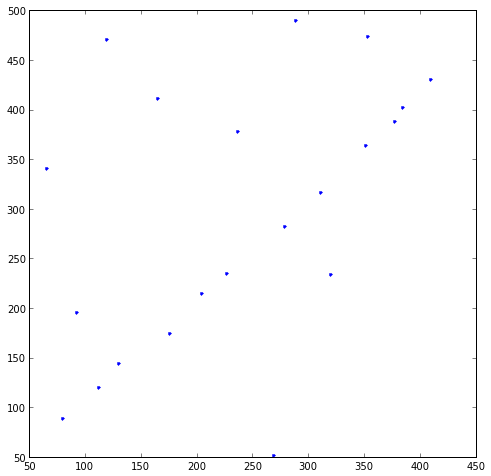

In [7]:
plot(points[:,0],points[:,1],'.')

# Robust Least Squares

Problem:

Why don't we just perform a global least square fit?

- images contain a large amount of clutter (points not belonging to the target object)
- if we add points that aren't part of the target line to the least square match, it will break the match

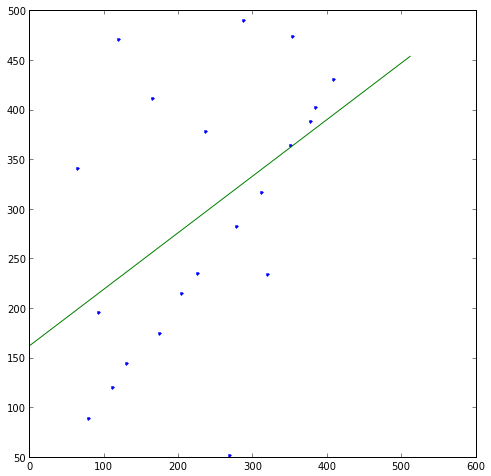

In [12]:
m,b = polyfit(points[:,0],points[:,1],1)
plot(points[:,0],points[:,1],'.')
plot([0,512],[b,m*512+b])

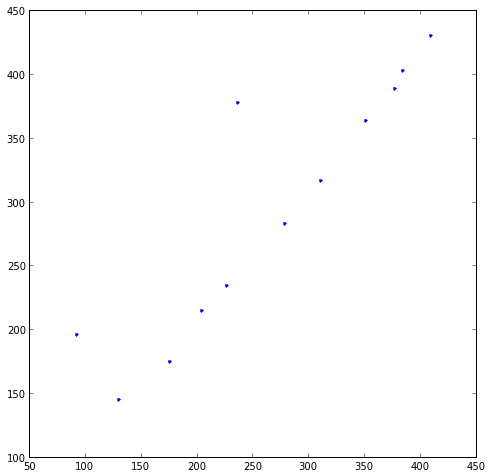

In [29]:
pred = m*points[:,0]+b
inlier = (abs(pred-points[:,1])<100)
plot(points[inlier,0],points[inlier,1],'.')

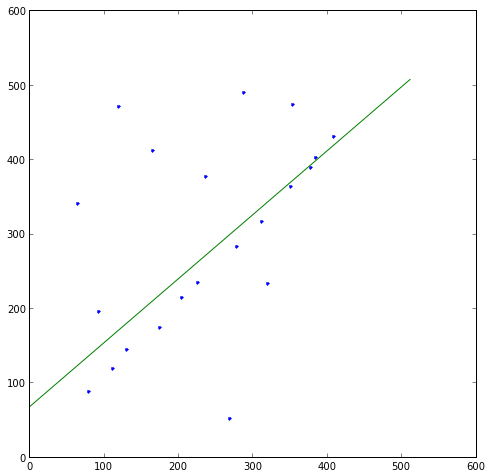

In [30]:
m,b = polyfit(points[inlier,0],points[inlier,1],1)
plot(points[:,0],points[:,1],'.')
plot([0,512],[b,m*512+b])

# RANSAC

RANSAC:

The idea behind RANSAC is the following:

- try a whole bunch of different line parameters
- determine which line matches the data best
- return those line parameters

Finding candidate lines:

- take any two points
- determine the line through them
- evaluate all the remaining points relative to that line

Evaluation of points:

- simple: if the point is within some error bound from the line it counts
- better: a smooth falloff $q=\max(1-\frac{\delta^2}{\epsilon^2},0)$

In [33]:
# evaluating a set of line parameters
def evaluate(points,m,b,eps=20):
    count = 0
    for x,y in points:
        error = abs(y-(m*x+b))
        count += max(1-error**2/eps**2,0)
    return count

In [37]:
# RANSAC
best = None
best_q = 0
for trial in range(10000):
    x0,y0 = points[randint(0,len(points)-1)]
    x1,y1 = points[randint(0,len(points)-1)]
    if abs(x1-x0)<5: continue
    m = (y1-y0)/(x1-x0)
    b = y0-m*x0
    q = evaluate(points,m,b)
    if q>best_q:
        best_q = q
        best = (m,b)
        print best_q,best

2.0 (-1.3421052631578947, 319.4736842105263)
10.0765766632 (1.015748031496063, 12.952755905511822)
10.9286148148 (1.0444444444444445, 1.9333333333332803)
11.1182718561 (1.0110294117647058, 9.128676470588232)
11.1569616826 (1.0136054421768708, 8.2244897959183731)
11.1746508366 (1.0150943396226415, 6.3094339622641655)
11.18229216 (1.032, 1.7680000000000007)
11.2197590203 (1.0209205020920502, 5.6569037656903731)


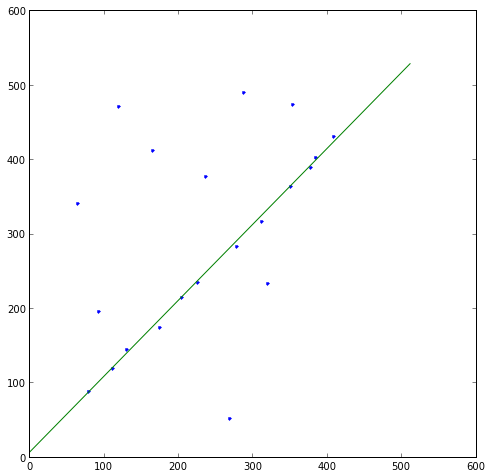

In [40]:
m,b = best
plot(points[:,0],points[:,1],'.')
plot([0,512],[b,m*512+b],'g-')